# Comparing with Schmalstieg Experimental Discharge Data

Validating parameter set (Figure 7 of part II paper)

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
You should consider upgrading via the '/home/katiez/FUSE/pybamm/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Load Schmalstieg discharge data

Time [s] vs Voltage [V]

In [2]:
voltage_data_1C = pd.read_csv("pybamm/input/discharge_data/Schmalstieg_1C_25degrees.csv", header=None).to_numpy()
voltage_data_2C = pd.read_csv("pybamm/input/discharge_data/Schmalstieg_2C_25degrees.csv", header=None).to_numpy()
voltage_data_3C = pd.read_csv("pybamm/input/discharge_data/Schmalstieg_3C_25degrees.csv", header=None).to_numpy()
voltage_data_5C = pd.read_csv("pybamm/input/discharge_data/Schmalstieg_5C_25degrees.csv", header=None).to_numpy()

Import model and parameter set

In [3]:
# choose DFN
model = pybamm.lithium_ion.DFN()

# pick parameters, keeping C-rate as an input to be changed for each solve
chemistry = pybamm.parameter_sets.Schmalstieg2018
parameter_values = pybamm.ParameterValues(chemistry=chemistry)
parameter_values.update({"Current function [A]": "[input]"})

Print parameter set

In [4]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.26,
 'Cell capacity [A.h]': 7.0,
 'Cell cooling surface area [m2]': 0.89,
 'Cell volume [m3]': 5.28e-05,
 'Current function [A]': InputParameter(-0x49db7630a7720d16, Current function [A], children=[], domain=[], auxiliary_domains={}),
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 3.75,
 'Electrode width [m]': 0.1185,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Schmalstieg2018 at 0x7fb81268e3b0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Schmalstieg2018 at 0x7fb81268e170>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 27234.87,
 'Initial concentration in positive electrode [mol.m-3]': 21059.33,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial

Choose mesh

In [5]:
var = pybamm.standard_spatial_vars
var_pts = {
    var.x_n: int(parameter_values.evaluate(model.param.L_n / 1e-6)),
    var.x_s: int(parameter_values.evaluate(model.param.L_s / 1e-6)),
    var.x_p: int(parameter_values.evaluate(model.param.L_p / 1e-6)),
    var.r_n: int(parameter_values.evaluate(model.param.R_n / 1e-7)),
    var.r_p: int(parameter_values.evaluate(model.param.R_p / 1e-7)),
}

Create simulation

In [6]:
sim =  pybamm.Simulation(model, parameter_values=parameter_values, var_pts=var_pts)

C/20

In [8]:
C_rates = [1/20]  # C-rates to solve for
capacity = parameter_values["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 50800, 5000)
] # times to return the solution at
solutions = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions[i] = sim.solution

2020-09-18 18:19:57,737 - [WARNING] legend._parse_legend_args(1247): No handles with labels found to put in legend.


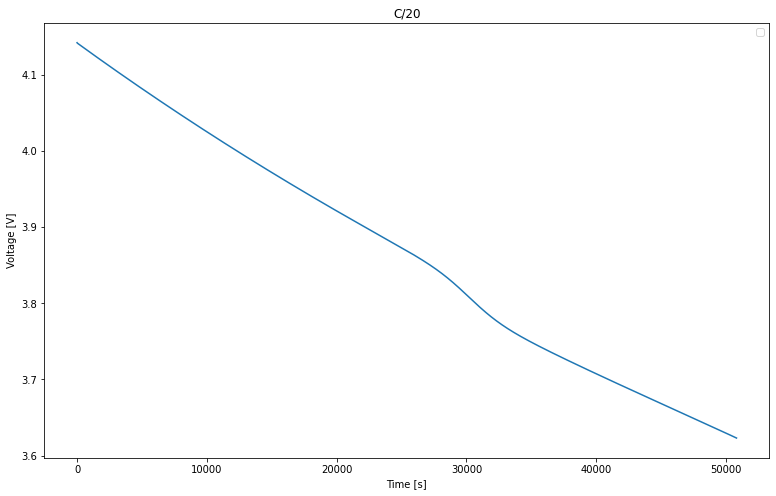

In [9]:
plt.figure(figsize=(13, 8))

t_sol = solutions[0]["Time [s]"].entries
plt.plot(t_sol, solutions[0]["Terminal voltage [V]"](t_sol))
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("C/20")
plt.legend(loc="best")

plt.show()

Solve for 1C, 2C, 3C and 5C

In [ ]:
C_rates = [1, 2, 3, 5]  # C-rates to solve for
capacity = parameter_values["Cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3200, 100), 
    np.linspace(0, 1540, 100), 
    np.linspace(0, 1020, 100), 
    np.linspace(0, 610, 100)
] # times to return the solution at
solutions = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions[i] = sim.solution

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = solutions[0]["Time [s]"].entries
ax1.plot(t_sol, solutions[0]["Terminal voltage [V]"](t_sol))
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C")
ax1.legend(["DFN", "Experiment"], loc="best")

# plot the 2C results
t_sol = solutions[1]["Time [s]"].entries
ax2.plot(t_sol, solutions[1]["Terminal voltage [V]"](t_sol))
ax2.plot(voltage_data_2C[:,0], voltage_data_2C[:,1], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("2C")
ax2.legend(["DFN", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 3C results
t_sol = solutions[2]["Time [s]"].entries
ax1.plot(t_sol, solutions[2]["Terminal voltage [V]"](t_sol))
ax1.plot(voltage_data_3C[:,0], voltage_data_3C[:,1], "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("3C")
ax1.legend(["DFN", "Experiment"], loc="best")

# plot the 5C results
t_sol = solutions[3]["Time [s]"].entries
ax2.plot(t_sol, solutions[3]["Terminal voltage [V]"](t_sol))
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C")
ax2.legend(["DFN", "Experiment"], loc="best")

plt.tight_layout()
plt.show()